## Importación modulos y datos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.read_csv("../Merge_20220730.csv", low_memory=False) 

## Exploración datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Lote       303 non-null    int64  
 1   Individuo  303 non-null    int64  
 2   AE         303 non-null    float64
 3   LE         303 non-null    float64
 4   AT         303 non-null    float64
 5   LT         303 non-null    float64
 6   AA         303 non-null    float64
 7   LA         303 non-null    float64
 8   NV         303 non-null    float64
 9   Morfotipo  303 non-null    object 
 10  Labio      303 non-null    int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 26.2+ KB


In [4]:
data.head()

,Lote,Individuo,AE,LE,AT,LT,AA,LA,NV,Morfotipo,Labio
0,96,5,6.14,1.80,13.72,10.00,8.13,6.08,5.12,LU,1
1,96,6,6.54,2.18,11.66,9.21,6.66,4.93,5.47,LU,0
2,99,19,6.92,2.10,13.67,10.43,8.23,6.05,5.22,LU,0
3,99,20,6.50,1.91,12.51,9.53,6.33,5.80,5.29,LU,0
4,99,21,6.08,1.74,12.70,9.27,7.59,5.73,5.23,LU,1


In [5]:
data["Morfotipo"].astype('category')

0      LU
1      LU
2      LU
3      LU
4      LU
       ..
298    LU
299    LB
300    LU
301    LU
302    LB
Name: Morfotipo, Length: 303, dtype: category
Categories (3, object): ['DU', 'LB', 'LU']

In [6]:
data.Morfotipo.value_counts()

LU    260
LB     41
DU      2
Name: Morfotipo, dtype: int64

In [7]:
data.iloc[:,2:-1].describe()

,AE,LE,AT,LT,AA,LA,NV
count,303.000000,303.000000,303.000000,303.00000,303.000000,303.000000,303.000000
mean,6.121881,1.753729,13.008317,9.63736,7.579802,6.062970,5.119208
std,0.976661,0.361996,1.930308,1.39747,1.215710,0.808302,0.299823
min,3.200000,0.710000,8.050000,6.24000,4.790000,4.270000,4.020000
25%,5.400000,1.485000,11.525000,8.68000,6.670000,5.470000,4.920000
50%,6.110000,1.760000,12.850000,9.55000,7.460000,5.970000,5.160000
75%,6.810000,2.010000,14.220000,10.64000,8.420000,6.610000,5.320000
max,9.040000,3.130000,19.090000,14.45000,11.950000,8.810000,5.900000


In [7]:
data.Labio.value_counts()

0    154
1    149
Name: Labio, dtype: int64

In [8]:
#Creamos un Filtro con NV > 4.75 y presencia de labio
data["Filtro_NV"] = np.where(np.logical_or(data["NV"] > 4.75, data["Labio"] == 1),True,False)

In [9]:
data.Filtro_NV.value_counts()

True     269
False     34
Name: Filtro_NV, dtype: int64

### Relación entre variables

<AxesSubplot:>

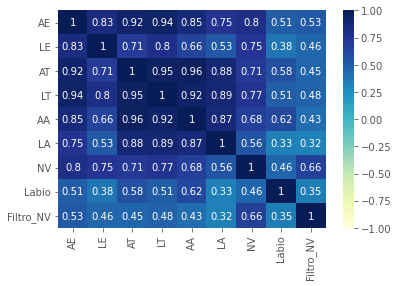

In [10]:
#variables originales del dataset
sns.heatmap(data.iloc[:,2:].corr(), vmin = -1, vmax = 1, center = 0, cmap = "YlGnBu", annot = True)

C:\Users\maela\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


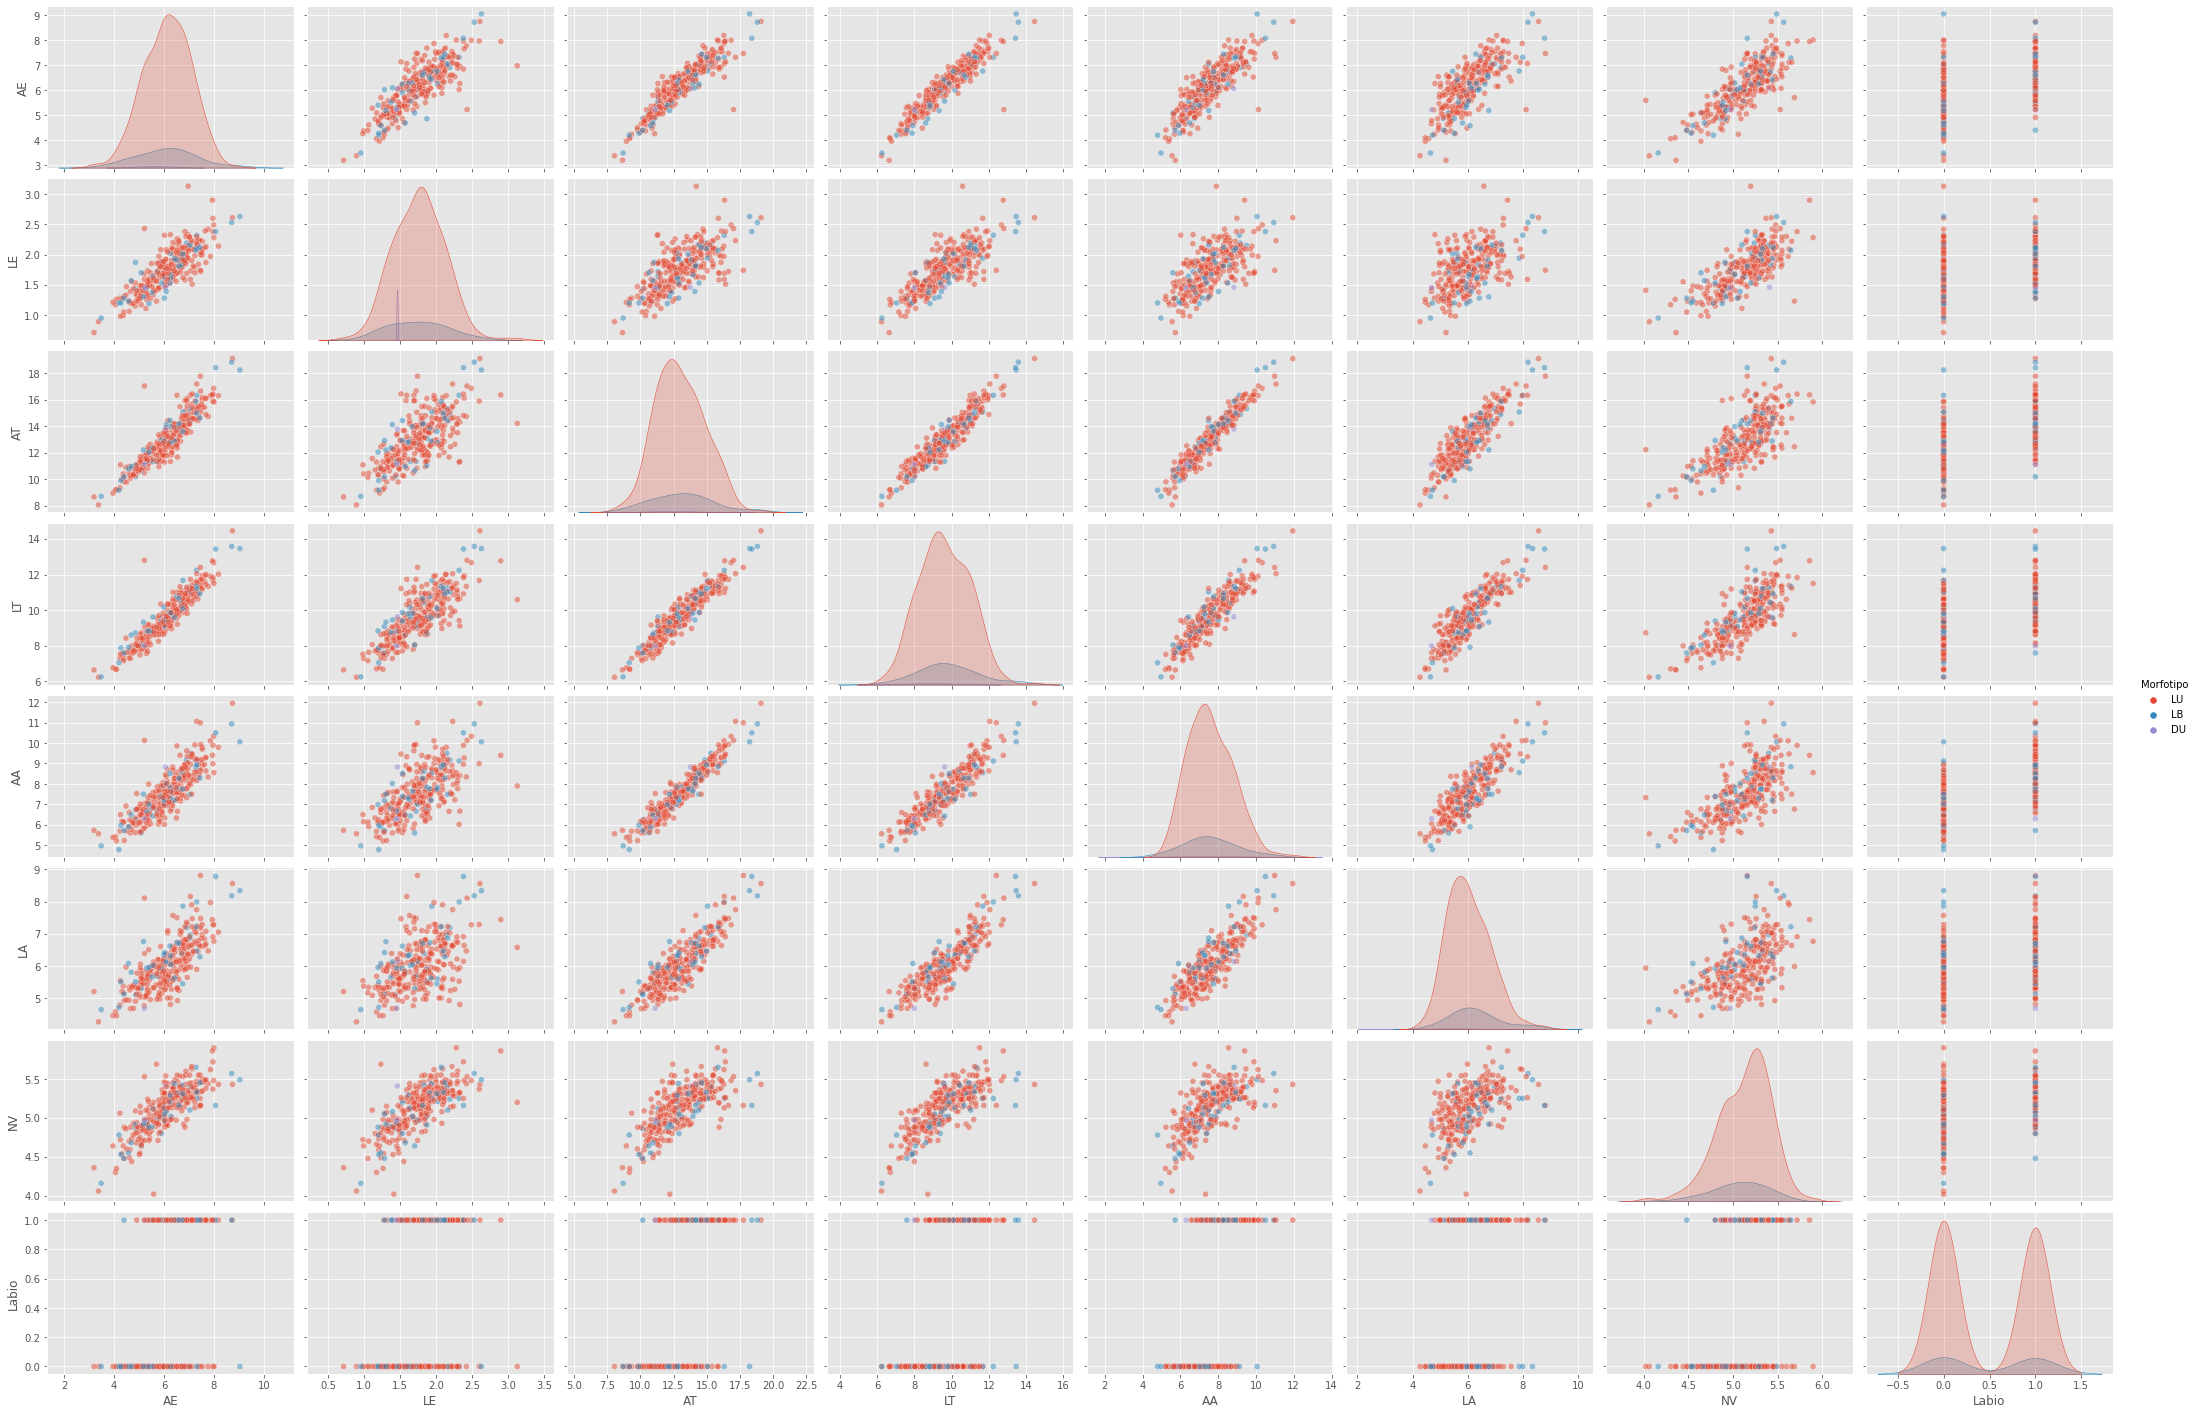

In [11]:
sns.pairplot(data=data,x_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],\
         y_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],hue='Morfotipo',plot_kws={'alpha': 0.5},aspect=1.5);

C:\Users\maela\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


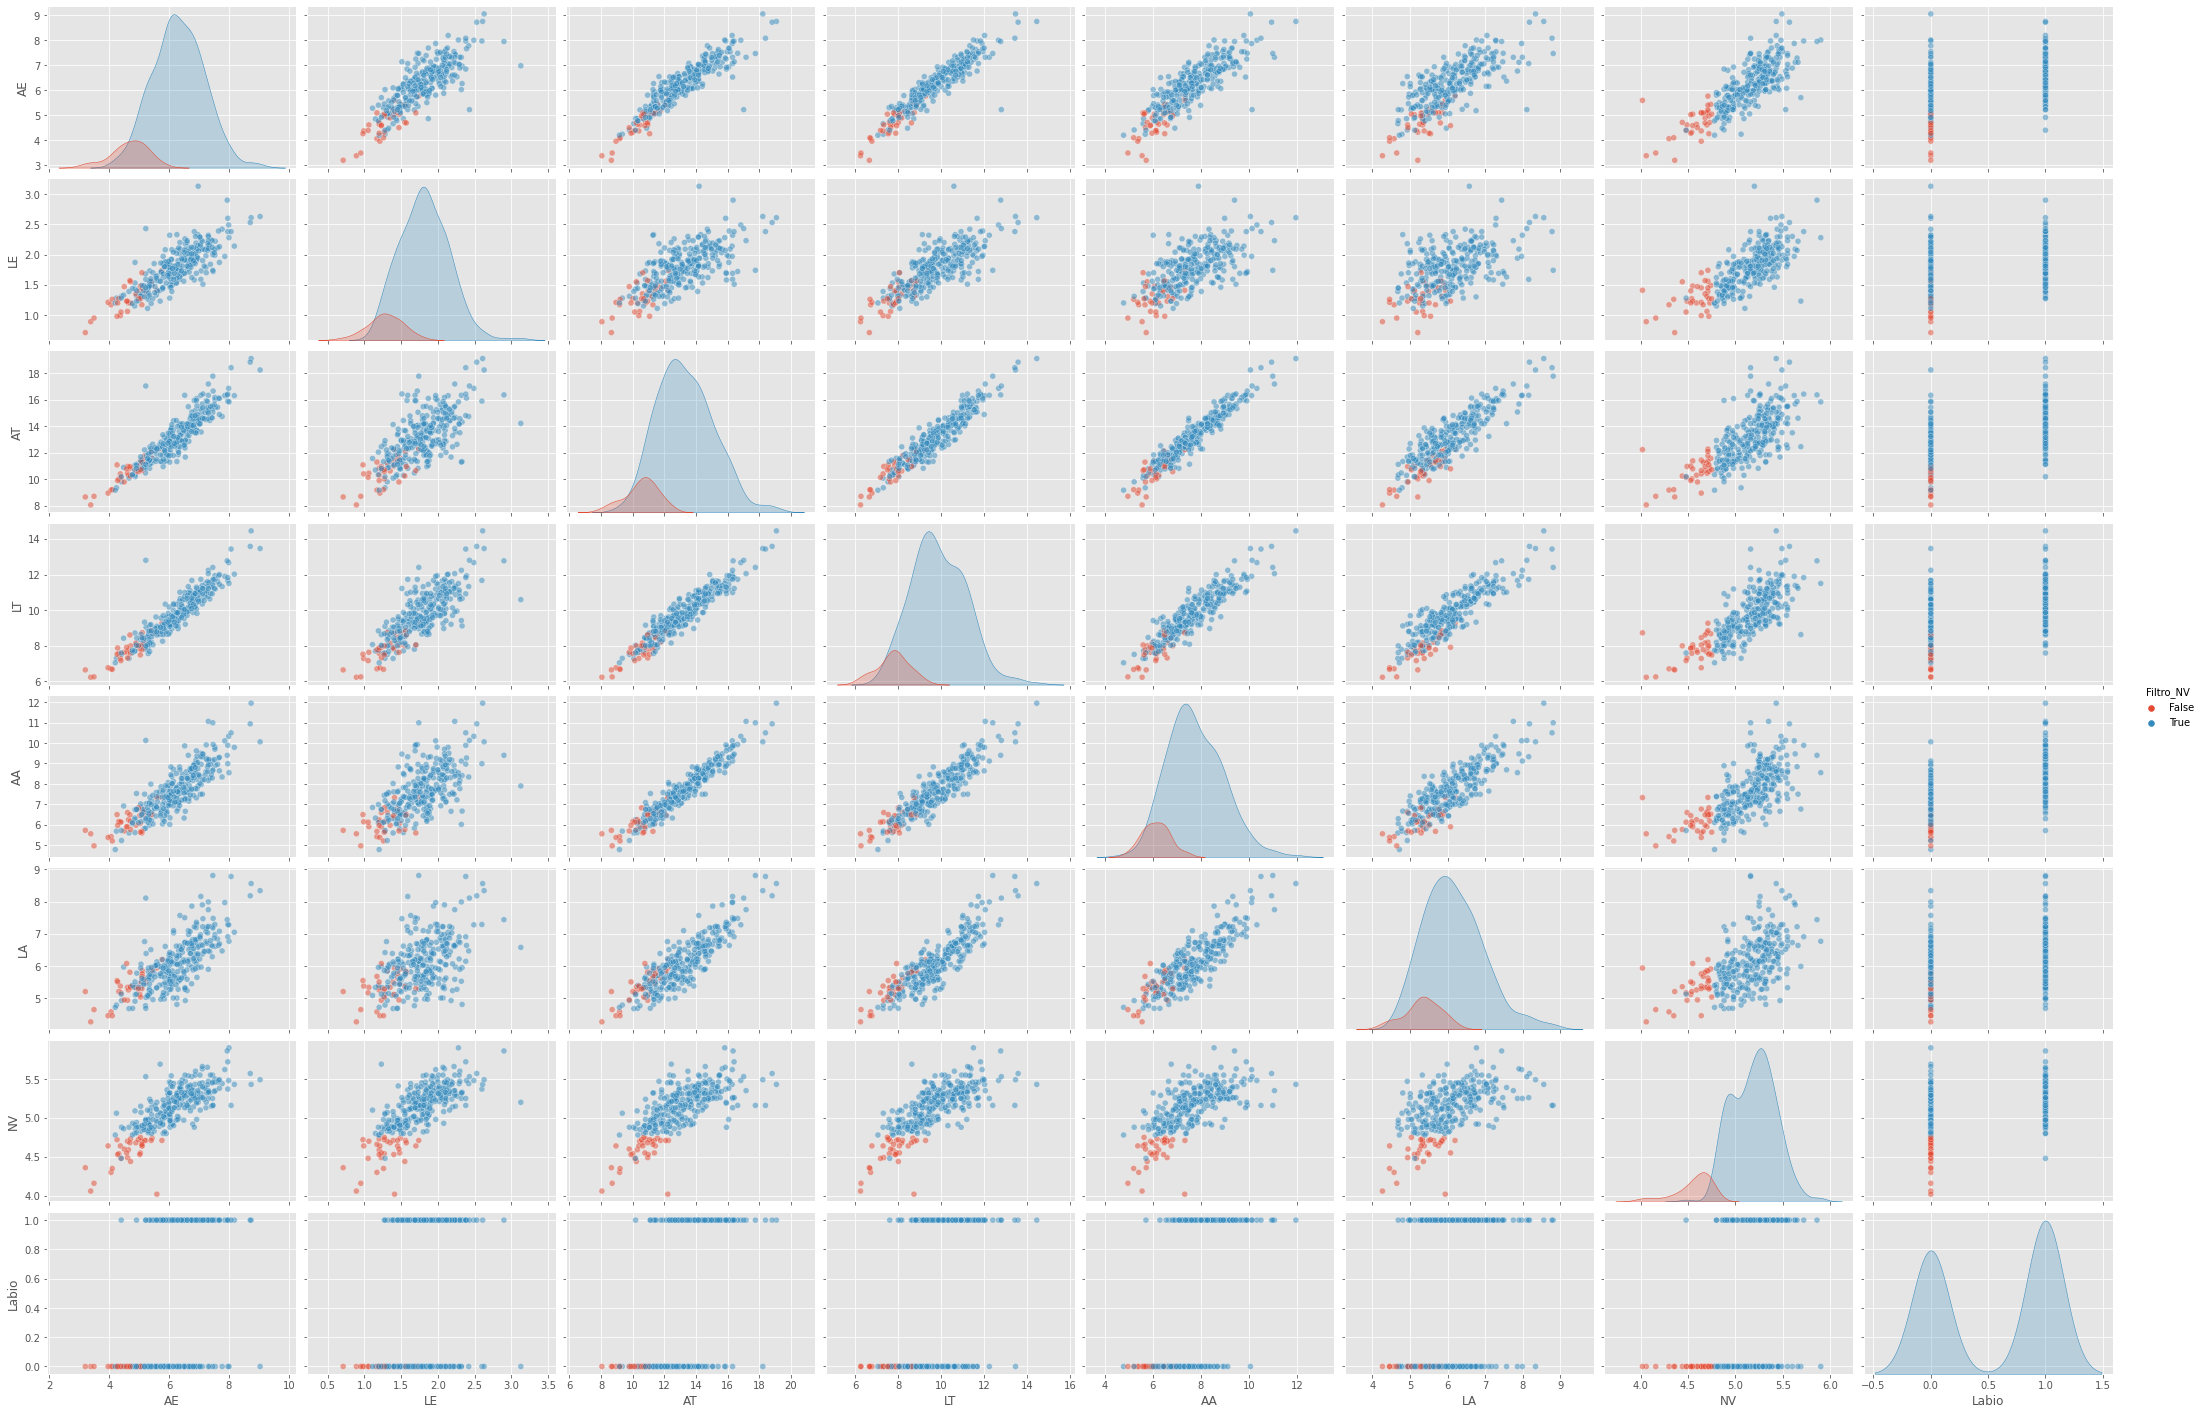

In [12]:
sns.pairplot(data=data,x_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],\
         y_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],hue='Filtro_NV',plot_kws={'alpha': 0.5},aspect=1.5);

In [16]:
def distribution_plotter(data, label, bins="auto"):    
    plt.figure(figsize = (10,5))
    sns.set_style("white")    
    dist = sns.histplot(data, bins=bins, stat = "count", kde = False, 
                        line_kws = {'linewidth':5}, 
                        binwidth = 500)    
    dist.set_title('Distribucion ', fontsize = 16)
    plt.xticks(rotation=45, ha='right')

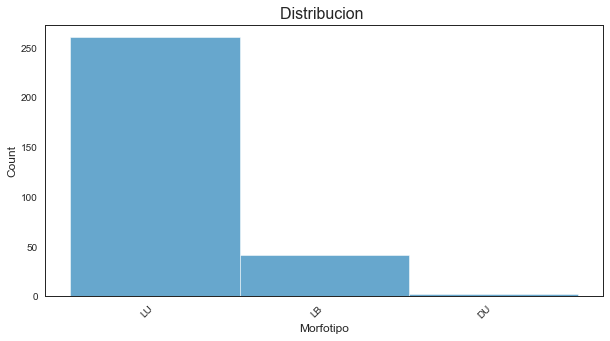

In [17]:
distribution_plotter(data["Morfotipo"],data["Morfotipo"].unique())

### Recuento por Etiqueta

In [13]:
print(pd.value_counts(data["Morfotipo"], sort = True, normalize=True))

LU    0.858086
LB    0.135314
DU    0.006601
Name: Morfotipo, dtype: float64


In [14]:
print(pd.value_counts(data["Filtro_NV"], sort = True, normalize=True))

True     0.887789
False    0.112211
Name: Filtro_NV, dtype: float64


### Distribución de las observaciones

array([[<AxesSubplot:title={'center':'AE'}>,
        <AxesSubplot:title={'center':'LE'}>,
        <AxesSubplot:title={'center':'AT'}>],
       [<AxesSubplot:title={'center':'LT'}>,
        <AxesSubplot:title={'center':'AA'}>,
        <AxesSubplot:title={'center':'LA'}>],
       [<AxesSubplot:title={'center':'NV'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

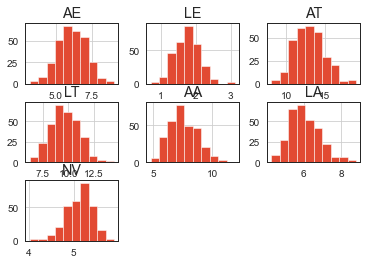

In [20]:
columns = data[["AE","LE","AT","LT","AA","LA","NV"]]
columns.hist()

## Creamos columnas de relación entre variables

In [16]:
data["Ratio_AE_LE"] = data["AE"]/data["LE"]
data["Ratio_AA_LA"] = data["AA"]/data["LA"]
data["Ratio_AT_LT"] = data["AT"]/data["LT"]

#aux copy: 'Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT','Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA'

In [22]:
data.head()

,Lote,Individuo,AE,LE,AT,LT,AA,LA,NV,Morfotipo,Labio,Filtro_NV,Ratio_AE_LE,Ratio_AA_LA,Ratio_AT_LT
0,96,5,6.14,1.80,13.72,10.00,8.13,6.08,5.12,LU,1,True,3.411111,1.337171,1.372000
1,96,6,6.54,2.18,11.66,9.21,6.66,4.93,5.47,LU,0,True,3.000000,1.350913,1.266015
2,99,19,6.92,2.10,13.67,10.43,8.23,6.05,5.22,LU,0,True,3.295238,1.360331,1.310642
3,99,20,6.50,1.91,12.51,9.53,6.33,5.80,5.29,LU,0,True,3.403141,1.091379,1.312697
4,99,21,6.08,1.74,12.70,9.27,7.59,5.73,5.23,LU,1,True,3.494253,1.324607,1.370011


### Nueva visualización

<AxesSubplot:>

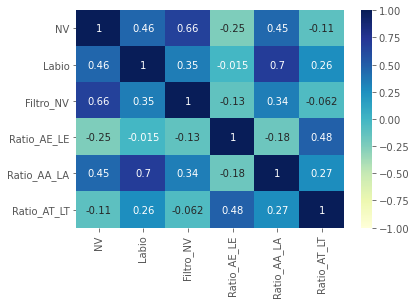

In [17]:
sns.heatmap(data.corr().iloc[8:,8:], vmin = -1, vmax = 1, center = 0, cmap = "YlGnBu", annot = True)

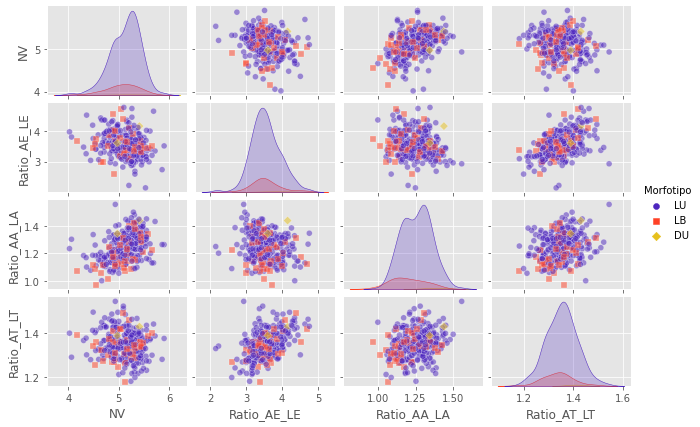

In [18]:
sns.pairplot(data=data,x_vars=['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT'],\
         y_vars=['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT'],\
             hue='Morfotipo',plot_kws={'alpha': 0.5},aspect=1.5, markers=['o','s','D'],palette='CMRmap', height=1.5);

## Exportación dataset listo

## Importación modulos y dataset

In [19]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

In [20]:
data.head()

,Lote,Individuo,AE,LE,AT,LT,AA,LA,NV,Morfotipo,Labio,Filtro_NV,Ratio_AE_LE,Ratio_AA_LA,Ratio_AT_LT
0,96,5,6.14,1.80,13.72,10.00,8.13,6.08,5.12,LU,1,True,3.411111,1.337171,1.372000
1,96,6,6.54,2.18,11.66,9.21,6.66,4.93,5.47,LU,0,True,3.000000,1.350913,1.266015
2,99,19,6.92,2.10,13.67,10.43,8.23,6.05,5.22,LU,0,True,3.295238,1.360331,1.310642
3,99,20,6.50,1.91,12.51,9.53,6.33,5.80,5.29,LU,0,True,3.403141,1.091379,1.312697
4,99,21,6.08,1.74,12.70,9.27,7.59,5.73,5.23,LU,1,True,3.494253,1.324607,1.370011


In [30]:
data.dtypes

Lote             int64
Individuo        int64
AE             float64
LE             float64
AT             float64
LT             float64
AA             float64
LA             float64
NV             float64
Morfotipo       object
Labio            int64
Filtro_NV         bool
Ratio_AE_LE    float64
Ratio_AA_LA    float64
Ratio_AT_LT    float64
dtype: object

## Prueba Kmeans

### Con las variables iniciales

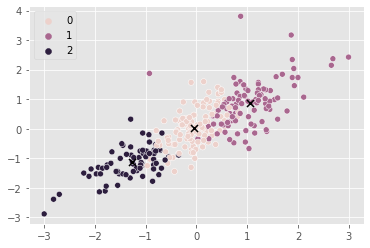

In [24]:
x = data[['AE','LE','AT','LT','AA','LA','NV']]
y_true = data["Morfotipo"]

scaler = StandardScaler()
x_scaled=scaler.fit_transform(x);

kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x_scaled[:,0],y=x_scaled[:,1],hue=labels,legend='full');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

Text(0.5, 1.0, 'Kmeans')

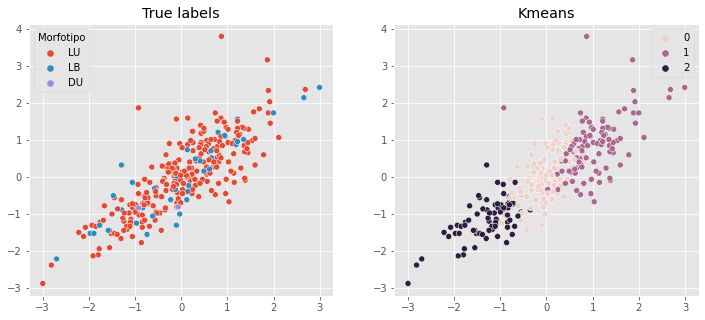

In [25]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=labels,ax=ax[1])
ax[1].set_title('Kmeans')

In [28]:
#no puede comparar etiquetas de letras con etiquetas numéricas
#sns.heatmap(confusion_matrix(y_true,labels),annot=True,cmap='Blues',fmt=".0f");

#print(classification_report(y_true,labels))

### Probamos KMEANS con todas las variables (menos Labio y Filtro_NV)

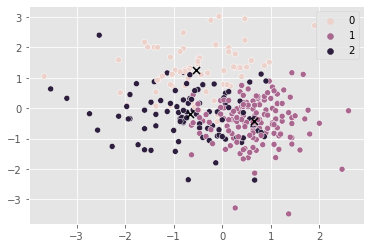

In [29]:
#x_R = data[['AE','LE','AT','LT','AA','LA','NV','Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT',\
#            'Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA']]
x_R = data[['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]
y_true = data["Morfotipo"]

scaler = StandardScaler()
x_R_scaled=scaler.fit_transform(x_R);

kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x_R_scaled)

labels_R = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids_R = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x_R_scaled[:,0],y=x_R_scaled[:,1],hue=labels_R,legend='full');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids_R[:,0],centroids_R[:,1],marker='x',s=50,color='k');

Text(0.5, 1.0, 'Kmeans_R')

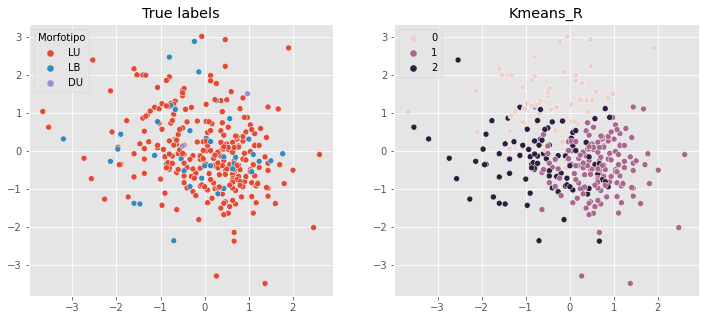

In [30]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=labels_R,ax=ax[1])
ax[1].set_title('Kmeans_R')

# Prueba PCA

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [32]:
std_sclr = StandardScaler()

X = data[['AE','LE','AT','LT','AA','LA','NV','Labio','Filtro_NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]

data_std = pd.DataFrame(std_sclr.fit_transform(X))

In [33]:
model = PCA()

In [35]:
model_pca = model.fit(data_std)

### Bastón quebrado

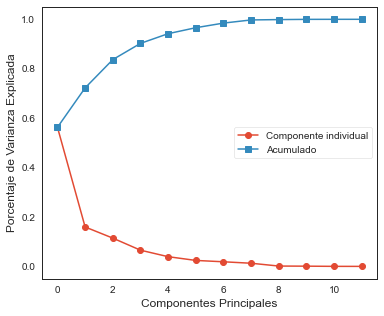

In [49]:
plt.figure(figsize=(6,5))

plt.plot(model_pca.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

In [38]:
#tabla de como aporta cada feature al componente
pca_df = pd.DataFrame(model_pca.components_, index =['AE','LE','AT','LT','AA','LA','NV','Labio','Filtro_NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT'], columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10','PC11', 'PC12'])
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
AE,0.365023,0.320020,0.366130,0.369244,0.359961,0.303914,0.325014,0.245990,0.229688,-0.077195,0.216844,0.011626
LE,0.012385,0.335791,-0.149685,0.039100,-0.160959,-0.104951,0.136687,-0.236241,0.096970,-0.595577,-0.134998,-0.607784
AT,-0.089002,0.079930,-0.144796,-0.205545,-0.084006,-0.472964,0.052981,0.406556,0.145681,-0.282854,0.623157,0.184594
LT,0.000497,0.188953,0.109780,0.090516,0.153465,0.097723,-0.322084,0.095956,-0.823209,-0.318553,0.117782,0.070596
AA,0.122265,0.267208,0.111354,-0.087929,-0.098214,-0.073392,0.072954,-0.569147,0.095626,-0.264019,-0.068121,0.682456
LA,-0.264302,0.000922,0.069453,-0.007085,-0.021649,0.239140,-0.369388,0.454328,0.342362,-0.401665,-0.440499,0.228397
NV,0.107099,0.076702,-0.027971,-0.064922,-0.325147,-0.132943,0.617486,0.391438,-0.324910,0.028468,-0.433466,0.159601
Labio,-0.593148,-0.295446,-0.059359,-0.085906,0.324719,0.305280,0.495705,-0.140602,-0.081361,-0.244249,0.126665,0.059426
Filtro_NV,-0.244345,-0.320896,0.542855,0.564559,-0.279462,-0.359951,0.010825,-0.075949,-0.008952,-0.096131,0.021824,-0.023598
Ratio_AE_LE,-0.591170,0.686942,0.031363,0.120255,-0.074611,-0.023936,-0.014668,0.008528,0.014157,0.395176,0.019259,-0.004489


### Proyección

In [51]:
#nuevo dataset con cada participación de feature
nuevo_data_pca = pd.DataFrame(model_pca.fit_transform(data_std), index =X.index, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10','PC11', 'PC12'])

In [52]:
nuevo_data_pca.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,0.997770,-0.409570,1.013453,0.195368,-0.273131,0.428366,-0.210187,0.100615,0.129568,-0.016843,-0.000558,0.001466
1,-0.009024,2.688327,1.416448,-0.445998,0.536885,-1.441032,0.144408,-0.142612,-0.050537,0.057175,-0.035788,-0.036574
2,1.354738,1.143311,0.205701,0.136352,0.562934,-1.038138,-0.942481,-0.141033,0.029461,-0.015740,0.008845,0.012173
3,-0.603604,1.518949,-1.002306,-0.827634,0.684343,-0.026499,0.881238,-0.524012,0.079787,-0.042681,0.026949,-0.014218
4,0.319570,-0.327244,1.310540,-0.253265,-0.303661,0.145429,0.302748,0.099727,-0.122254,-0.056245,-0.013441,0.001098
5,0.876250,0.697510,1.261171,-0.086546,-0.721842,-0.163209,0.204277,-0.277662,-0.077464,-0.018273,-0.012134,0.003396
6,-0.747624,-0.748579,1.259713,-0.538401,-0.449900,0.467901,0.362560,0.314216,0.040169,-0.017225,-0.013832,0.007546
7,-0.548041,1.617110,0.142458,-0.690012,0.442690,-0.694745,0.228689,-0.063554,-0.148609,-0.068163,0.016351,-0.014857
8,-0.045035,-0.234290,1.666218,-0.558644,-0.432786,-0.358178,0.538401,-0.302721,-0.159149,-0.054204,-0.033852,-0.008112
9,0.349263,2.980296,2.736417,0.209015,-0.655457,-0.250443,0.407377,-0.439824,-0.259811,0.226293,-0.060694,-0.045265


In [32]:
nuevo_data_pca.shape

(303, 17)

### Pesos (loadings)

In [39]:
# me quedo con los primeros 5 componentes
pca_loadings = pd.DataFrame(model_pca.components_.T, index=X.columns).iloc[:,:4]
pca_loadings.rename(columns = {0 : 'CP1', 1 : 'CP2', 2 : 'CP3', 3 : 'CP4'}, inplace = True)
pca_loadings

,CP1,CP2,CP3,CP4
AE,0.365023,0.012385,-0.089002,0.000497
LE,0.320020,0.335791,0.079930,0.188953
AT,0.366130,-0.149685,-0.144796,0.109780
LT,0.369244,0.039100,-0.205545,0.090516
AA,0.359961,-0.160959,-0.084006,0.153465
LA,0.303914,-0.104951,-0.472964,0.097723
NV,0.325014,0.136687,0.052981,-0.322084
Labio,0.245990,-0.236241,0.406556,0.095956
Filtro_NV,0.229688,0.096970,0.145681,-0.823209
Ratio_AE_LE,-0.077195,-0.595577,-0.282854,-0.318553


In [54]:
def plot_explained_variance(components_count, X):

    model_pca = PCA(components_count).fit(X)

    explained_variance = model_pca.explained_variance_ratio_

    #print(explained_variance)

    cumulative_explained_variance = np.cumsum(explained_variance)

    #print(cumulative_explained_variance)

    plt.plot(cumulative_explained_variance)
    plt.xlabel('número de componentes')
    plt.ylabel('% de varianza explicada');

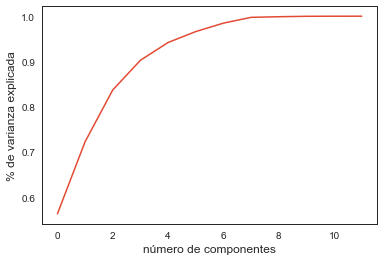

In [56]:
plot_explained_variance(components_count = 12, X = data_std)

## Prueba TSNE

In [57]:
from sklearn.manifold import TSNE

In [58]:
tsne = TSNE(random_state=42)

proj_tsne = tsne.fit_transform(data_std)

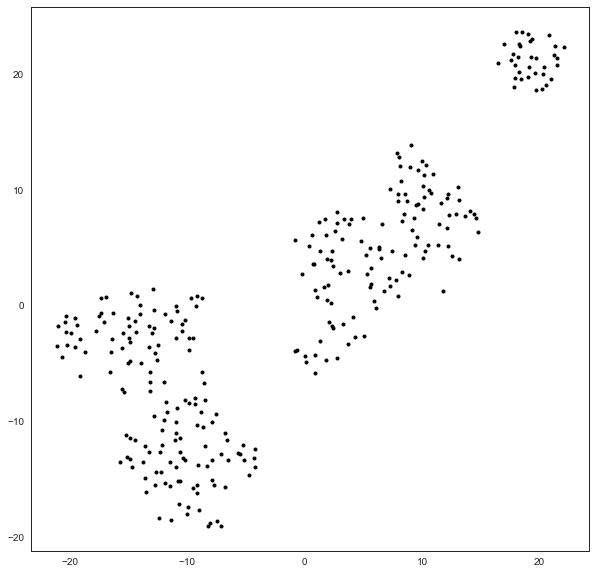

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne[:, 0]
coord_y = proj_tsne[:, 1]
ax.plot(coord_x, coord_y, '.k')    

## CART con oversampling

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
newX = data[['AE','LE','AT','LT','AA','LA','NV','Labio','Filtro_NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]
newy = data['Morfotipo']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(newX,newy,stratify = data['Morfotipo'],random_state=0)

In [63]:
# chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (227, 12)
Testeo: (76, 12)

Clases train:
LU    0.859031
LB    0.136564
DU    0.004405
Name: Morfotipo, dtype: float64

Clases test:
LU    0.855263
LB    0.131579
DU    0.013158
Name: Morfotipo, dtype: float64


### OverSampling

In [64]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
DU    195
LU    195
LB     31
Name: Morfotipo, dtype: int64

Composición del test set:
LU    65
LB    10
DU     1
Name: Morfotipo, dtype: int64


In [65]:
X_train_os2,y_train_os2=oversampler.fit_resample(X_train_os,y_train_os);

print('Composición del training set:')
print(y_train_os2.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
DU    195
LU    195
LB    195
Name: Morfotipo, dtype: int64

Composición del test set:
LU    65
LB    10
DU     1
Name: Morfotipo, dtype: int64


### Smote

In [66]:
from imblearn.over_sampling import SMOTE

In [67]:
smote = SMOTE()
Xsmote, ysmote = smote.fit_resample(X_train, y_train)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

## CART

In [68]:
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix

In [71]:
clf_dt = DecisionTreeClassifier(max_depth = 7, random_state=42)
clf_dt = clf_dt.fit(X_train_os2,y_train_os2)

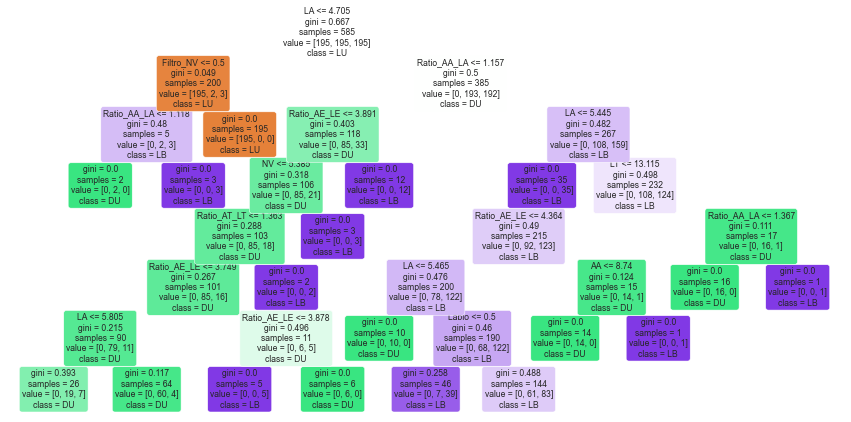

In [72]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["LU","DU", "LB"], 
          feature_names=X_train_os2.columns); 

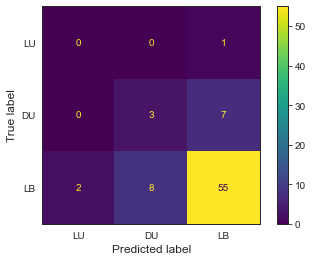

In [73]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["LU","DU","LB"])